<a href="https://colab.research.google.com/github/raulbenitez/ML_DL_INTERPRETABILITY/blob/main/DL/DL_MNIST_Interpretability_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load MNIST data

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Load data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Train DL model

Both feature extraction and classification are performed using a simple custom-made CNN architecture trained with the MNIST training subset.
MNIST classification using a simple CNN architecture

From: https://keras.io/examples/vision/mnist_convnet/


### Build and train

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [4]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [9]:
batch_size =256
epochs = 5
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
211/211 [==============================] - 35s 161ms/step - loss: 0.5143 - accuracy: 0.8479 - val_loss: 0.1117 - val_accuracy: 0.9687
Epoch 2/5
211/211 [==============================] - 34s 163ms/step - loss: 0.1426 - accuracy: 0.9567 - val_loss: 0.0699 - val_accuracy: 0.9803
Epoch 3/5
211/211 [==============================] - 31s 147ms/step - loss: 0.1022 - accuracy: 0.9690 - val_loss: 0.0542 - val_accuracy: 0.9860
Epoch 4/5
211/211 [==============================] - 33s 154ms/step - loss: 0.0869 - accuracy: 0.9739 - val_loss: 0.0472 - val_accuracy: 0.9883
Epoch 5/5
211/211 [==============================] - 31s 145ms/step - loss: 0.0738 - accuracy: 0.9770 - val_loss: 0.0442 - val_accuracy: 0.9882


### Evaluate

In [12]:
from sklearn.metrics import classification_report

score = model.evaluate(x_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

y_test_pred_DL_full = np.argmax(model.predict(x_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.04425692930817604
Test accuracy: 0.986299991607666
313/313 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

        zero       0.98      1.00      0.99       980
         one       0.99      1.00      0.99      1135
         two       0.98      0.99      0.98      1032
       three       0.99      0.98      0.99      1010
        four       0.98      0.99      0.99       982
        five       0.99      0.99      0.99       892
         six       0.99      0.99      0.99       958
       seven       0.97      0.98      0.98      1028
       eight       0.98      0.98      0.98       974
        nine       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# DL interpretability

Let's apply some DL interpretability techniques to further understand the DL feature extraction and classification procedure. Let's consider the full DL model architecture

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

Check dimensions of all convolutional layers in the architecture

In [14]:
for layer in model.layers:
	if 'conv' not in layer.name:
		continue
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d (3, 3, 1, 32)
conv2d_1 (3, 3, 32, 64)


## Visualize filters weights

Let's visualize the trained weights of the filters in the first convolutional layer

In [15]:
filters, biases = model.layers[0].get_weights()
from matplotlib import pyplot

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

filters.shape
filters1 = filters.squeeze()

In the first convolutional layer there are 32 filters, each of size 3x3


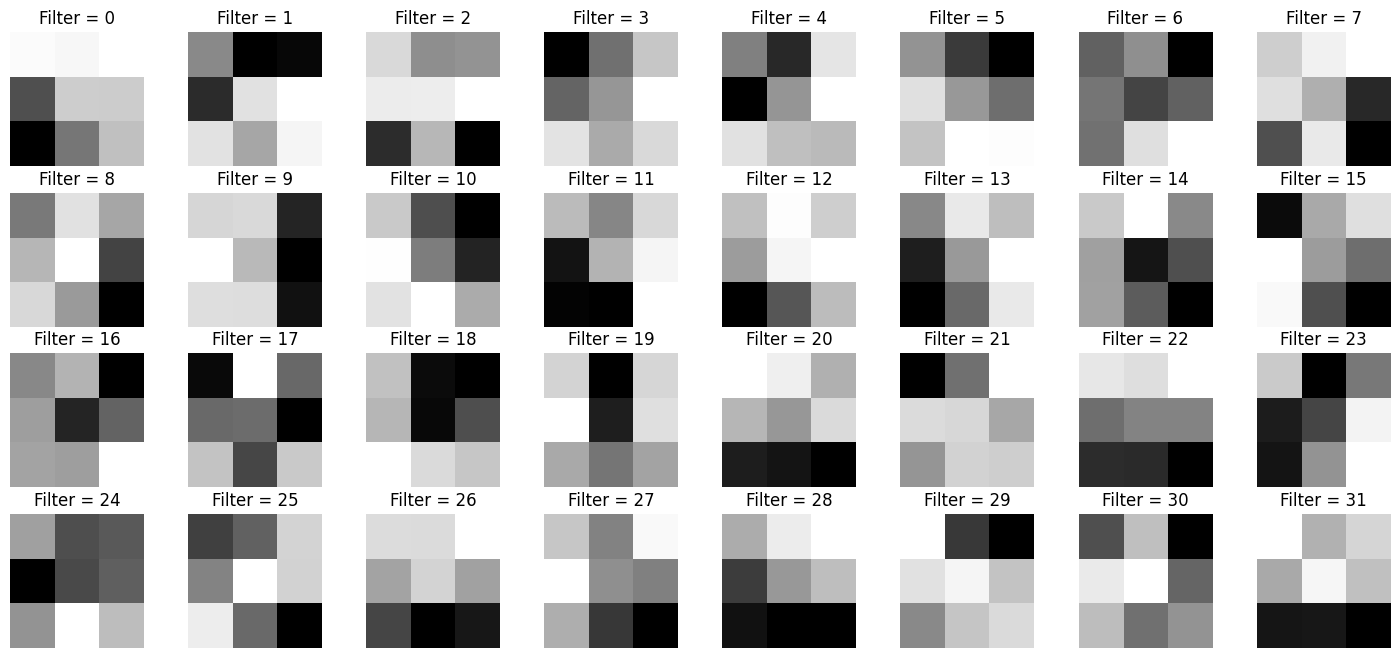

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
for kfilt in range(0,32):
    ax = fig.add_subplot(4, 8, kfilt+1)
    ax.imshow(filters1[:,:,kfilt], cmap='gray')
    ax.set_title('Filter = {}'.format(kfilt))
    ax.axis('off')

## Vizualize the feature maps

Feature maps are the result of projecting an input image across the different convolutional filters in the convolutional layers of the CNN.

In [17]:
from tensorflow.keras.models import Model

# define a new model with outputs the first layer
model_feat_layer0  = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_feat_layer0.summary()

# extract the features provided by the model of the test input
feat_test_layer0 = model_feat_layer0.predict(x_test)

print('layer 0 shape {}'.format(feat_test_layer0.shape))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 4ms/step
layer 0 shape (10000, 26, 26, 32)


plot the feature maps corresponding to the first image in the test subset, which in this case corresponds to a

In [18]:
y_test[0]

7

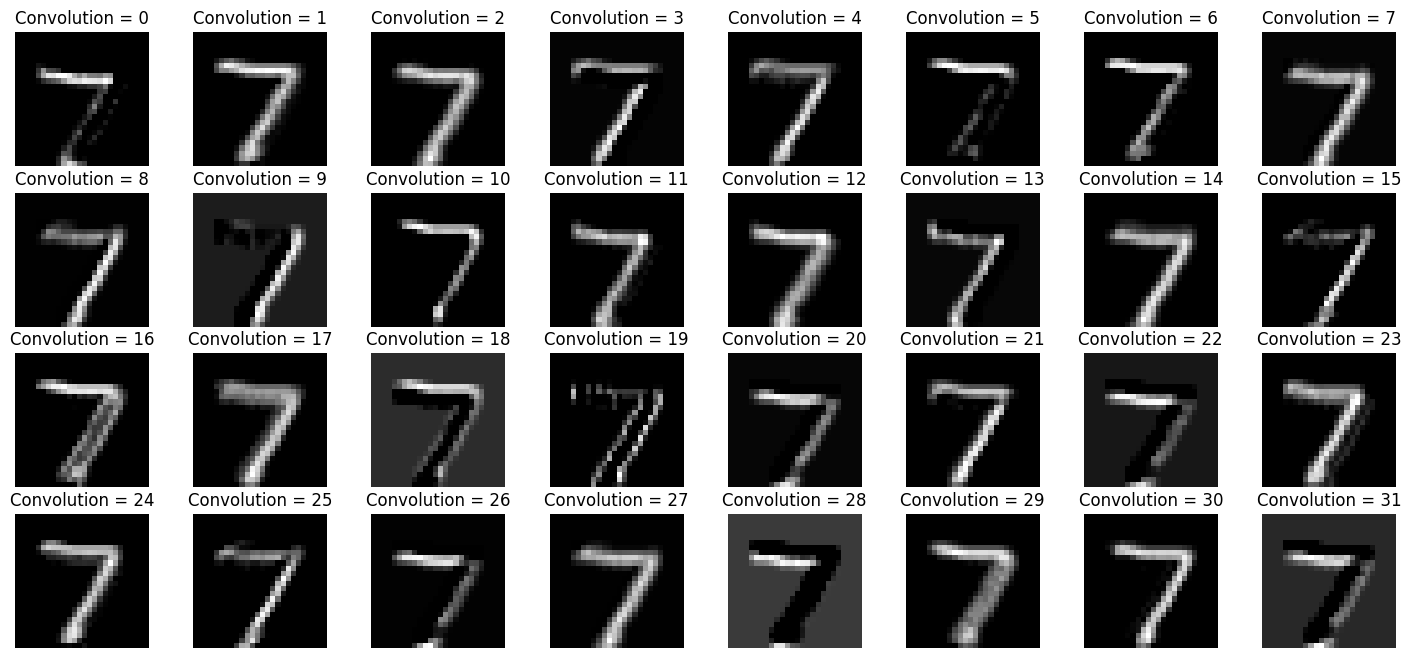

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
for kfeat in range(0,32):
    ax = fig.add_subplot(4, 8, kfeat+1)
    ax.imshow(feat_test_layer0[0,:,:,kfeat], cmap='gray')
    ax.set_title('Convolution = {}'.format(kfeat))
    ax.axis('off')

## Activation Maximization

https://raghakot.github.io/keras-vis/visualizations/activation_maximization/

Generate an input image that maximizes the filter output activations. i.e., we compute

$\frac{\partial ActivationMaximizationLoss}{\partial input}$

and use that estimate to update the input. ActivationMaximization loss simply outputs small values for large filter activations (we are minimizing losses during gradient descent iterations). This allows us to understand what sort of input patterns activate a particular filter. For example, there could be an eye filter that activates for the presence of eye within the input image.

In [20]:
!pip install tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 4.9 MB/s eta 0:00:00


Change final activation layer from softmax to linear.
To compute the gradients, it is recommended to change the softmax activation function by
a linear function, since with the softmax the maximization of a class can be achieved by
minimising the scores of the other classes, and using a linear function we ensure that the
optimization concentrates only on the class in question.

In [21]:
from tf_keras_vis.activation_maximization import ActivationMaximization
import tensorflow as tf

def model_modifier(current_model):
    current_model.layers[-1].activation = tf.keras.activations.linear
    return current_model

activation_maximization = ActivationMaximization(model,model_modifier,clone=False)

Score function to maximize a certain category

In [22]:
from tf_keras_vis.utils.scores import CategoricalScore

class_score = 9
score = CategoricalScore(class_score)

In [23]:
from tf_keras_vis.activation_maximization.callbacks import PrintLogger as Logger
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D

# Generate maximized activation
activations = activation_maximization(score,callbacks=[Logger(interval=50)])

<ipython-input-23-575e38e8be74>:5: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activations = activation_maximization(score,callbacks=[Logger(interval=50)])


Steps: 050	Scores: [[107.0589828491211]],	Regularization: [('TotalVariation2D', [16.63874626159668]), ('Norm', [34.71525573730469])]
Steps: 100	Scores: [[-201.8804931640625]],	Regularization: [('TotalVariation2D', [11.160360336303711]), ('Norm', [30.70933723449707])]
Steps: 150	Scores: [[-258.9507141113281]],	Regularization: [('TotalVariation2D', [9.618680953979492]), ('Norm', [28.050138473510742])]
Steps: 200	Scores: [[-148.61383056640625]],	Regularization: [('TotalVariation2D', [8.15612506866455]), ('Norm', [25.572620391845703])]


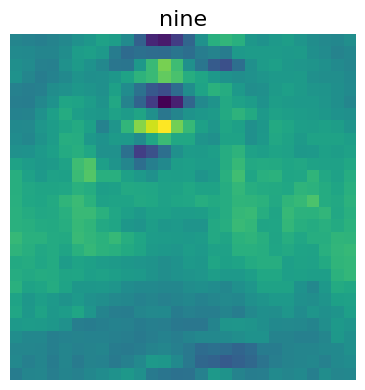

In [25]:
# Visualize
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(np.squeeze(activations))
ax.set_title(class_names[class_score], fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

Let's do the same procedure with all the other digits:

In [ ]:
fig = plt.figure(figsize=(18, 8))
for kclass in range(0,10):
    score = CategoricalScore(kclass)
    activation_maximization = ActivationMaximization(model,model_modifier,clone=False)
    activations = activation_maximization(score,callbacks=[Logger(interval=50)])
    ax = fig.add_subplot(2, 5, kclass+1)
    ax.imshow(np.squeeze(activations))
    ax.set_title(class_names[kclass], fontsize=16)
    ax.axis('off')

<ipython-input-26-952120c4a21d>:5: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activations = activation_maximization(score,callbacks=[Logger(interval=50)])


Steps: 050	Scores: [[-123.71678924560547]],	Regularization: [('TotalVariation2D', [25.050277709960938]), ('Norm', [34.11522674560547])]
Steps: 100	Scores: [[500.46905517578125]],	Regularization: [('TotalVariation2D', [13.996923446655273]), ('Norm', [32.11552810668945])]
Steps: 150	Scores: [[195.71255493164062]],	Regularization: [('TotalVariation2D', [10.415980339050293]), ('Norm', [30.75913429260254])]
Steps: 200	Scores: [[106.59308624267578]],	Regularization: [('TotalVariation2D', [8.723583221435547]), ('Norm', [29.35279655456543])]
Steps: 050	Scores: [[-324.4898986816406]],	Regularization: [('TotalVariation2D', [19.095443725585938]), ('Norm', [34.03248977661133])]
Steps: 100	Scores: [[447.05889892578125]],	Regularization: [('TotalVariation2D', [12.356322288513184]), ('Norm', [32.9455680847168])]
Steps: 150	Scores: [[-211.94354248046875]],	Regularization: [('TotalVariation2D', [9.796029090881348]), ('Norm', [31.793670654296875])]
Steps: 200	Scores: [[414.9046630859375]],	Regularizatio

## Gradient-based interpretability

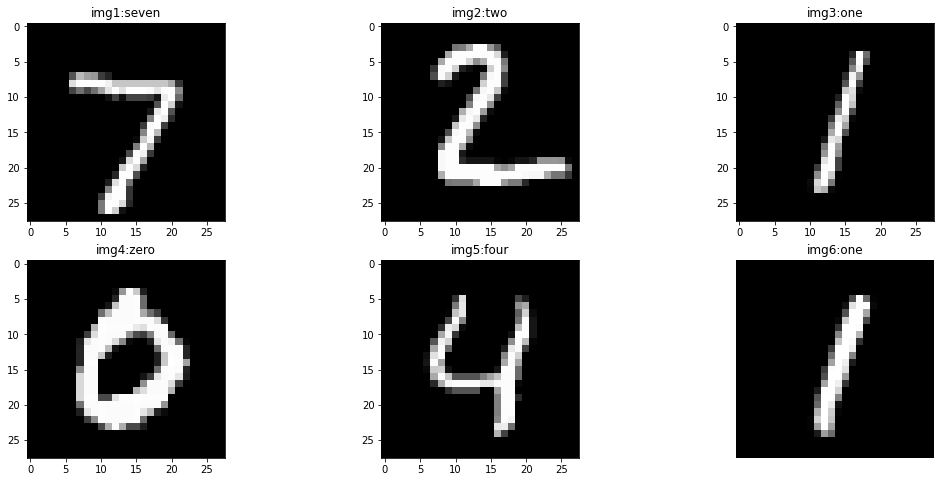

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

# Image titles
image_titles = ['seven', 'two', 'one','zero','four','one']

# Load images and Convert them to a Numpy array
img1 = x_test[0].reshape(28,28)
img2 = x_test[1].reshape(28,28)
img3 = x_test[2].reshape(28,28)
img4 = x_test[3].reshape(28,28)
img5 = x_test[4].reshape(28,28)
img6 = x_test[5].reshape(28,28)

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(2, 3, 1)
ax.imshow(img1, cmap='gray')
ax.set_title('img1:'+ image_titles[0])
ax = fig.add_subplot(2, 3, 2)
ax.imshow(img2, cmap='gray')
ax.set_title('img2:'+ image_titles[1])
ax = fig.add_subplot(2,3, 3)
ax.imshow(img3, cmap='gray')
ax.set_title('img3:' + image_titles[2])
ax = fig.add_subplot(2,3, 4)
ax.imshow(img4, cmap='gray')
ax.set_title('img4:' + image_titles[3])
ax = fig.add_subplot(2,3, 5)
ax.imshow(img5, cmap='gray')
ax.set_title('img5:' + image_titles[4])
ax = fig.add_subplot(2,3, 6)
ax.imshow(img6, cmap='gray')
ax.set_title('img6:' + image_titles[5])
ax.axis('off')
plt.show()



### GradCam

Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

https://arxiv.org/abs/1610.02391




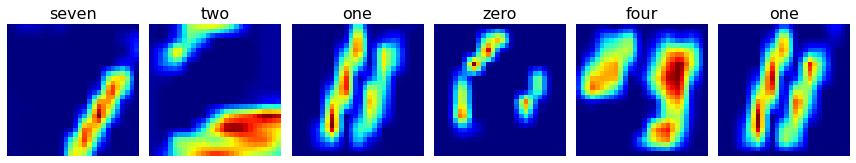

In [ ]:
images = np.asarray([np.array(img1), np.array(img2), np.array(img3),np.array(img4),np.array(img5),np.array(img6)])
X = images.reshape(6,28,28,1)

score = CategoricalScore([7, 2, 1, 0, 4, 1])

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,model_modifier=model_modifier,clone=False)

# Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()


### GradCam++

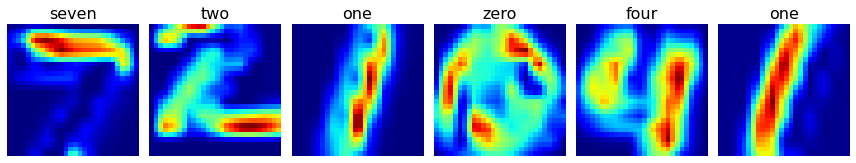

In [ ]:
from tf_keras_vis.gradcam import GradcamPlusPlus

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create GradCAM++ object and repalce class name to "GradcamPlusPlus"
gradcamplus = GradcamPlusPlus(model,model_modifier,clone=False)

# Generate heatmap with GradCAM
camplus = gradcamplus(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(camplus[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

